In [2]:
# Stock Movement Prediction - MSFT Dataset

# === 1. Data Preparation ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

plt.show()


In [3]:

# Load data
df = pd.read_csv("MSFT.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

# Add target: 1 if next day Close > today Close
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# === 2. Feature Engineering ===
df['DailyReturn'] = (df['Close'] - df['Open']) / df['Open']
df['Volatility'] = (df['High'] - df['Low']) / df['Open']
df['Close_Open_Diff'] = df['Close'] - df['Open']

# Lag features
df['Close_t-1'] = df['Close'].shift(1)
df['Volume_t-1'] = df['Volume'].shift(1)
df['DailyReturn_t-1'] = df['DailyReturn'].shift(1)

# Moving averages
df['SMA_3'] = df['Close'].rolling(3).mean()
df['SMA_7'] = df['Close'].rolling(7).mean()

# Drop rows with NA
features = ['DailyReturn', 'Volatility', 'Close_Open_Diff', 'Close_t-1', 'Volume_t-1',
            'DailyReturn_t-1', 'SMA_3', 'SMA_7']
df = df.dropna(subset=features + ['Target'])



C:\Users\tania\AppData\Local\Temp\ipykernel_8680\2881459805.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


In [4]:
# === 3. Train/Test Split ===
X = df[features]
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [5]:
# === 4. Train Models ===
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

results = {}

for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'conf_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': roc_curve(y_test, y_proba)
    }



[LightGBM] [Info] Number of positive: 3667, number of negative: 3739
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 7406, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495139 -> initscore=-0.019444
[LightGBM] [Info] Start training from score -0.019444


                     Accuracy  F1 Score  Precision    Recall   ROC AUC
Logistic Regression  0.517279  0.358680   0.623441  0.251762  0.552062
Random Forest        0.488661  0.244214   0.588462  0.154079  0.514711
LightGBM             0.474622  0.141218   0.571429  0.080564  0.513773
CatBoost             0.465443  0.071295   0.520548  0.038268  0.507706


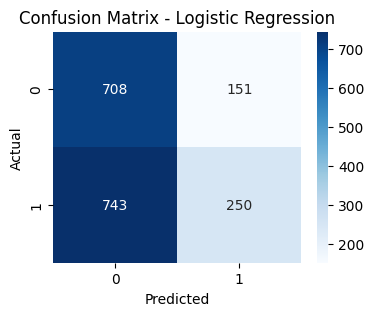

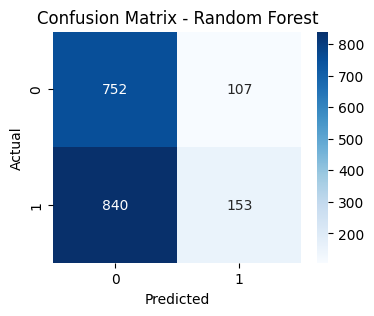

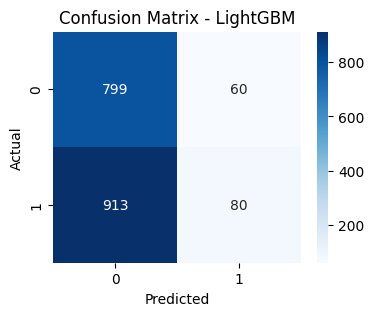

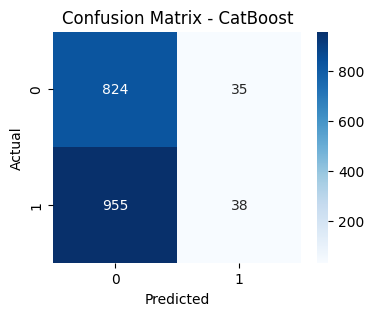

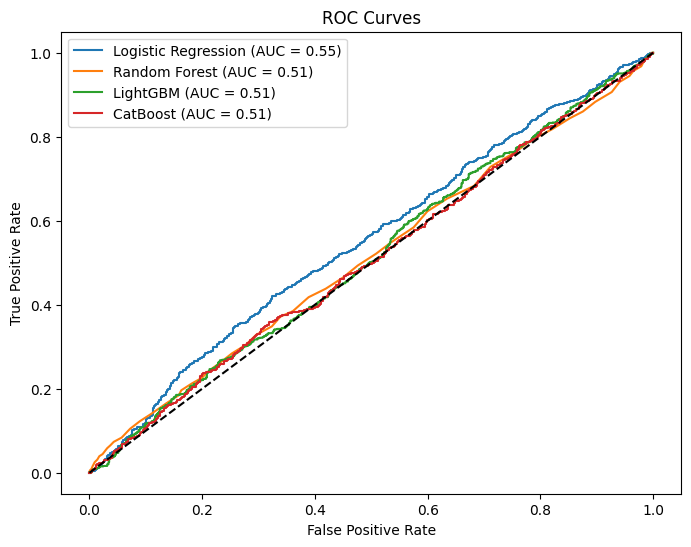

In [6]:
# === 5. Comparison ===
# Table of metrics
metrics_df = pd.DataFrame({model: {
    'Accuracy': res['accuracy'],
    'F1 Score': res['f1'],
    'Precision': res['precision'],
    'Recall': res['recall'],
    'ROC AUC': res['roc_auc']
} for model, res in results.items()}).T
print(metrics_df)

# Confusion matrices
for name, res in results.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(res['conf_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ROC curves
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = res['roc_curve']
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()